In [ ]:
!gdown --id 1rosMro9S7FJ9qkUon1kxwvqcIOrQ3-RT -O data.arff

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rosMro9S7FJ9qkUon1kxwvqcIOrQ3-RT
To: /content/data.arff
100% 3.66M/3.66M [00:00<00:00, 136MB/s]


Preoprocessing

Useful info: age, marital status, education, default, balance, housing, loan, duration, campaign, poutcome

In [ ]:
import csv

# Function to map education to a numeric value
def map_education(education):
    if education == 'secondary':
        return 1
    elif education == 'tertiary':
        return 2
    else:
        return 0
    

def pos_or_neg(status):
    if status == 'divorced' or status == 'failure':
        return -1
    elif status == 'married' or status == 'success':
        return 1
    else:
        return 0

def read(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        arff_data = infile.readlines()
        csv_writer = csv.writer(outfile)

        # Write the header
        header = ['age', 'marital_status', 'education', 'balance', 'credit_in_default', 'housing_loan', 'personal_loan', 'seconds_of_contact', 'outcome_of_previous_contact', 'result']
        csv_writer.writerow(header)

        for line in arff_data[98:]:  # Skip the first 98 lines because they are not data
            if line.startswith('@') or line.strip() == '':
                continue

            data = line.strip().split(',')
            cleaned_data = [
                int(data[0]),  # age
                pos_or_neg(data[2]),  # marital status
                map_education(data[3]),  # education
                int(data[5]),  # balance
                0 if data[4] == 'no' else 1,  # credit in default
                0 if data[6] == 'no' else 1,  # housing loan
                0 if data[7] == 'no' else 1,  # personal loan
                int(data[11]),  # seconds of contact
                pos_or_neg(data[15]),  # outcome of previous contact
                int(data[16])  # result
            ]
            csv_writer.writerow(cleaned_data)
read('data.arff', 'cleaned_data.csv')

# You do not have to run the following sequentially

Logistic Regression

We did some hyperparameter tuning and added regularization to out logistic regression function. To use adaptive learning rates we used the liblinear solver. We also scaled and fit our data before running the gradient ascent fit algorithm. We tried performing polynomial regression as well but the results were consistantly worse than using a scaled version of our data.

The result was a Logistic Regression function that achieved a roughly 89% accuracy. Regardless of how we tuned our parameters and which solver we used, we were unable to go above 89.5%.

Accuracy Score (Test Set): 0.8926570333235034


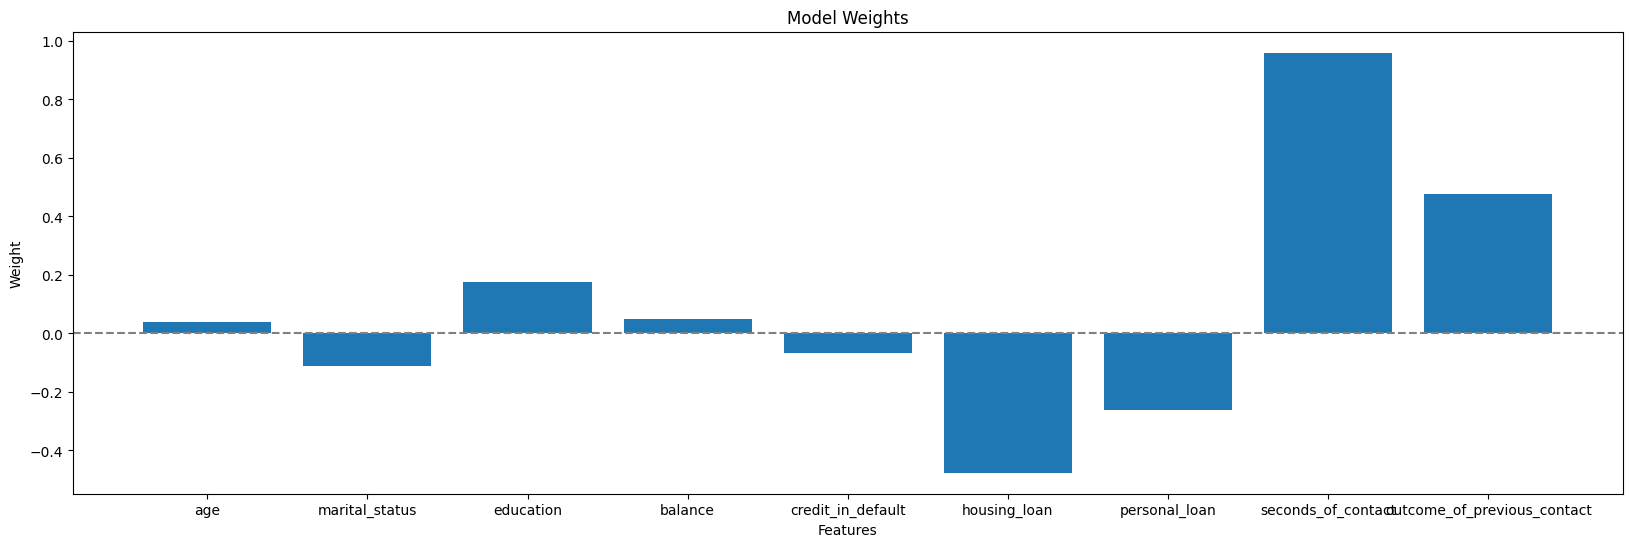

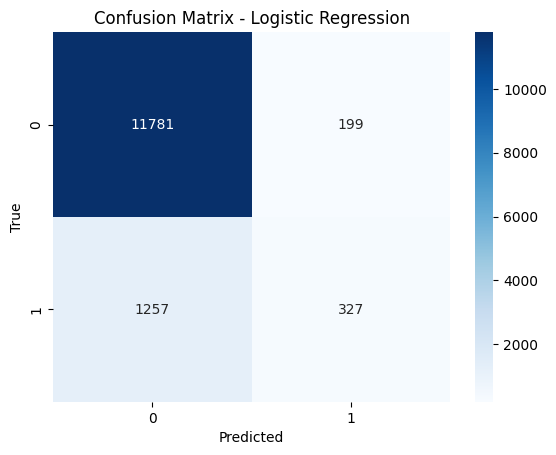

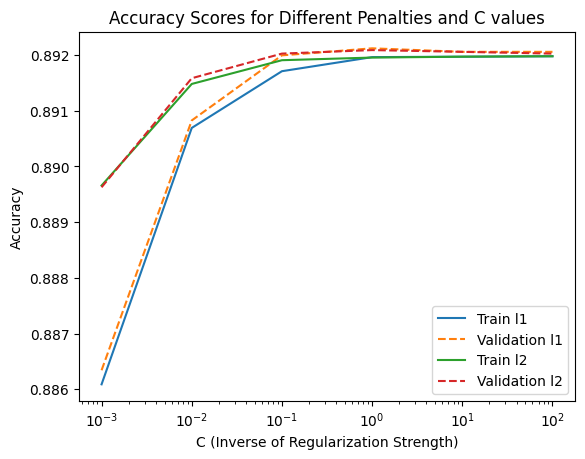

Results for Penalty: l1
C: 0.001 Train Accuracy: 0.8861 Validation Accuracy: 0.8863
C: 0.01 Train Accuracy: 0.8907 Validation Accuracy: 0.8908
C: 0.1 Train Accuracy: 0.8917 Validation Accuracy: 0.8920
C: 1.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8921
C: 10.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8921
C: 100.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8921
Results for Penalty: l2
C: 0.001 Train Accuracy: 0.8897 Validation Accuracy: 0.8896
C: 0.01 Train Accuracy: 0.8915 Validation Accuracy: 0.8916
C: 0.1 Train Accuracy: 0.8919 Validation Accuracy: 0.8920
C: 1.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8921
C: 10.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8921
C: 100.0 Train Accuracy: 0.8920 Validation Accuracy: 0.8920


0.8926570333235034

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

def load_data(file_path):
    return pd.read_csv(file_path)

def prepare_data(data, target_var):
    X = data.drop(target_var, axis=1).to_numpy()
    y = data[target_var].to_numpy()
    return X, y

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def tune_hyperparameters(X_train, y_train):
    model = LogisticRegression(solver='liblinear', max_iter=50000)
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_, grid_search.cv_results_


def train_best_model(X_train, y_train, best_params):
    best_model = LogisticRegression(solver='liblinear', max_iter=50000, **best_params)
    best_model.fit(X_train, y_train)
    return best_model

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# def plot_accuracy_scores(cv_results):
#     train_scores = cv_results['mean_train_score']
#     test_scores = cv_results['mean_test_score']
#     penalties = [f"{p['penalty']}" for p in cv_results['params']]

#     fig, ax = plt.subplots()
#     ax.plot(penalties, train_scores, label='Training', marker='o')
#     ax.plot(penalties, test_scores, label='Validation', marker='o')
#     ax.set_xlabel('Penalty')
#     ax.set_ylabel('Accuracy')
#     ax.set_title('Accuracy Scores for Different Penalties')
#     ax.legend()
#     plt.show()
def plot_accuracy_scores(cv_results):
    penalties = [p['penalty'] for p in cv_results['params']]
    Cs = [p['C'] for p in cv_results['params']]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'Penalty': penalties,
        'C': Cs,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    fig, ax = plt.subplots()
    for penalty in results_df['Penalty'].unique():
        plot_data = results_df[results_df['Penalty'] == penalty]
        ax.plot(plot_data['C'], plot_data['Train Accuracy'], label=f"Train {penalty}")
        ax.plot(plot_data['C'], plot_data['Validation Accuracy'], label=f"Validation {penalty}", linestyle='--')

    ax.set_xscale('log')
    ax.set_xlabel('C (Inverse of Regularization Strength)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Scores for Different Penalties and C values')
    ax.legend()
    plt.show()
    
def plot_confusion_matrix_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

def print_accuracy_scores(cv_results):
    penalties = [p['penalty'] for p in cv_results['params']]
    Cs = [p['C'] for p in cv_results['params']]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'Penalty': penalties,
        'C': Cs,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    for penalty in results_df['Penalty'].unique():
        print(f"Results for Penalty: {penalty}")
        plot_data = results_df[results_df['Penalty'] == penalty]
        for index, row in plot_data.iterrows():
            print(f"C: {row['C']} Train Accuracy: {row['Train Accuracy']:.4f} Validation Accuracy: {row['Validation Accuracy']:.4f}")

def print_model_weights(best_model, feature_names):
    weights = best_model.coef_
    bias = best_model.intercept_
    
    print("Weights:")
    for feature_name, weight in zip(feature_names, weights[0]):
        print(f"{feature_name}: {weight:.4f}")
    print(f"Bias: {bias[0]:.4f}")

def plot_model_weights(best_model, feature_names):
    weights = best_model.coef_
    bias = best_model.intercept_

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bar(feature_names, weights[0])
    ax.set_title("Model Weights")
    ax.set_xlabel("Features")
    ax.set_ylabel("Weight")
    ax.axhline(y=0, color='gray', linestyle='--')
    plt.show()

def Logistic():
    data = load_data('cleaned_data.csv')
    X, y = prepare_data(data, 'result')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    best_params, best_score, cv_results = tune_hyperparameters(X_train_scaled, y_train)
    best_model = train_best_model(X_train_scaled, y_train, best_params)
    test_accuracy = evaluate_model(best_model, X_test_scaled, y_test)
    print("Accuracy Score (Test Set):", test_accuracy)
    
    feature_names = data.drop('result', axis=1).columns
    plot_model_weights(best_model, feature_names)

    y_pred = best_model.predict(X_test_scaled)
    plot_confusion_matrix_heatmap(y_test, y_pred)
    plot_accuracy_scores(cv_results)
    print_accuracy_scores(cv_results)

    return test_accuracy

Logistic()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(file_path):
    return pd.read_csv(file_path)

def prepare_data(data, target_var):
    X = data.drop(target_var, axis=1).to_numpy()
    y = data[target_var].to_numpy()
    return X, y

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def tune_hyperparameters(X_train, y_train):
    model = SVC(kernel='linear')
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': [0.001, 0.01, 0.1, 1]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_, grid_search.cv_results_

def train_best_model(X_train, y_train, best_params):
    best_model = SVC(**best_params)
    best_model.fit(X_train, y_train)
    return best_model

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def plot_accuracy_scores(cv_results):
    penalties = cv_results['params']
    Cs = [p['C'] for p in penalties]
    kernels = [p['kernel'] for p in penalties]
    gammas = [p['gamma'] if 'gamma' in p else 'scale' for p in penalties]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'C': Cs,
        'Kernel': kernels,
        'Gamma': gammas,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    fig, ax = plt.subplots()
    for kernel in results_df['Kernel'].unique():
        for gamma in results_df['Gamma'].unique():
            plot_data = results_df[(results_df['Kernel'] == kernel) & (results_df['Gamma'] == gamma)]
            ax.plot(plot_data['C'], plot_data['Train Accuracy'], label=f"Train {kernel} (Gamma: {gamma})")
            ax.plot(plot_data['C'], plot_data['Validation Accuracy'], label=f"Validation {kernel} (Gamma: {gamma})", linestyle='--')

    ax.set_xscale('log')
    ax.set_xlabel('C (Inverse of Regularization Strength)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Scores for Different Kernels, C values, and Gamma values')
    ax.legend()
    plt.show()

def print_accuracy_scores(cv_results):
    penalties = cv_results['params']
    Cs = [p['C'] for p in penalties]
    kernels = [p['kernel'] for p in penalties]
    gammas = [p['gamma'] if 'gamma' in p else 'scale' for p in penalties]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'C': Cs,
        'Kernel': kernels,
        'Gamma': gammas,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    print(results_df.to_string(index=False))

def plot_confusion_matrix_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - SVM")
    plt.show()

def svm():
    data = load_data('cleaned_data.csv')
    X, y = prepare_data(data, 'result')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    best_params, best_score, cv_results = tune_hyperparameters(X_train_scaled, y_train)
    best_model= train_best_model(X_train_scaled, y_train, best_params)
    
    test_accuracy = evaluate_model(best_model, X_test, y_test)
    print("Accuracy Score (Test Set):", test_accuracy)
    
    y_pred = best_model.predict(X_test_scaled)
    plot_confusion_matrix_heatmap(y_test, y_pred)

    print("Best Hyperparameters:", best_params)
    print("Best Cross Validation Accuracy:", best_score)
    plot_accuracy_scores(cv_results)
    print_accuracy_scores(cv_results)

svm()

ValueError: ignored

Accuracy Score (Test Set): 0.896711884399882


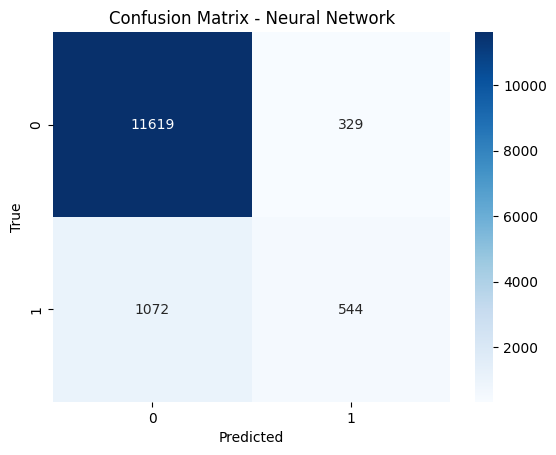

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best Cross Validation Accuracy: 0.9023920382541609


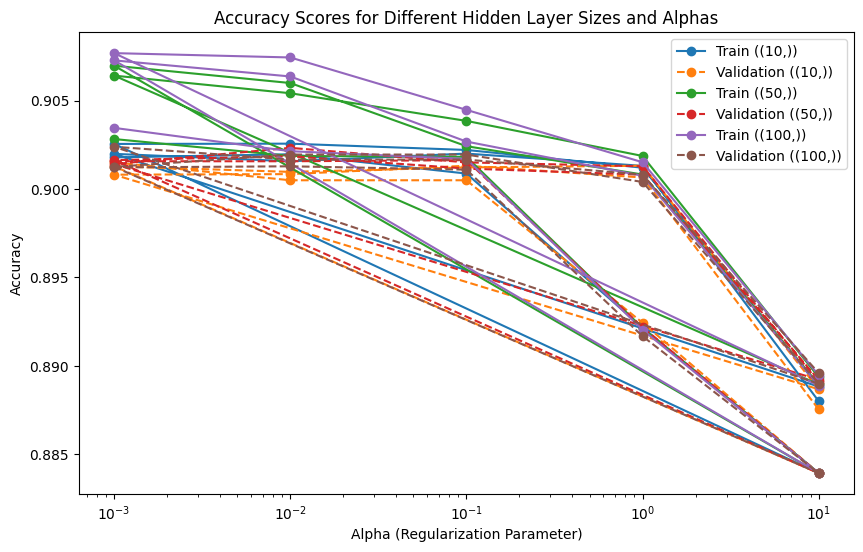

   Hidden Layer Sizes Activation   Alpha  Train Accuracy  Validation Accuracy
0               (10,)   logistic   0.001        0.901792             0.901507
1               (50,)   logistic   0.001        0.902826             0.901570
2              (100,)   logistic   0.001        0.903458             0.901223
3               (10,)   logistic   0.010        0.901965             0.900496
4               (50,)   logistic   0.010        0.901871             0.901570
5              (100,)   logistic   0.010        0.902139             0.901286
6               (10,)   logistic   0.100        0.900875             0.900496
7               (50,)   logistic   0.100        0.901823             0.901634
8              (100,)   logistic   0.100        0.901705             0.901096
9               (10,)   logistic   1.000        0.892170             0.892438
10              (50,)   logistic   1.000        0.892146             0.892186
11             (100,)   logistic   1.000        0.892043        

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

def load_data(file_path):
    return pd.read_csv(file_path)

def prepare_data(data, target_var):
    X = data.drop(target_var, axis=1).to_numpy()
    y = data[target_var].to_numpy()
    return X, y

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def tune_hyperparameters(X_train, y_train):
    model = MLPClassifier(solver='adam', max_iter=1000)
    param_grid = {
        'hidden_layer_sizes': [(10,), (50,), (100,)],
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_, grid_search.cv_results_


def train_best_model(X_train, y_train, best_params):
    best_model = MLPClassifier(solver='adam', max_iter=1000, **best_params)
    best_model.fit(X_train, y_train)
    return best_model

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def plot_accuracy_scores(cv_results):
    hidden_layer_sizes = [str(p['hidden_layer_sizes']) for p in cv_results['params']]
    activations = [p['activation'] for p in cv_results['params']]
    alphas = [p['alpha'] for p in cv_results['params']]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'Hidden Layer Sizes': hidden_layer_sizes,
        'Activation': activations,
        'Alpha': alphas,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    fig, ax = plt.subplots(figsize=(10, 6))
    for size in results_df['Hidden Layer Sizes'].unique():
        plot_data = results_df[results_df['Hidden Layer Sizes'] == size]
        ax.plot(plot_data['Alpha'], plot_data['Train Accuracy'], label=f"Train ({size})", marker='o')
        ax.plot(plot_data['Alpha'], plot_data['Validation Accuracy'], label=f"Validation ({size})", linestyle='--', marker='o')

    ax.set_xscale('log')
    ax.set_xlabel('Alpha (Regularization Parameter)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Scores for Different Hidden Layer Sizes and Alphas')
    ax.legend()
    plt.show()

def print_accuracy_scores(cv_results):
    hidden_layer_sizes = [str(p['hidden_layer_sizes']) for p in cv_results['params']]
    activations = [p['activation'] for p in cv_results['params']]
    alphas = [p['alpha'] for p in cv_results['params']]
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']

    results_df = pd.DataFrame({
        'Hidden Layer Sizes': hidden_layer_sizes,
        'Activation': activations,
        'Alpha': alphas,
        'Train Accuracy': train_scores,
        'Validation Accuracy': test_scores
    })

    print(results_df)

    
def plot_confusion_matrix_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Neural Network")
    plt.show()

def NeuralNet():
    data = load_data('cleaned_data.csv')
    X, y = prepare_data(data, 'result')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    best_params, best_score, cv_results = tune_hyperparameters(X_train_scaled, y_train)
    best_model = train_best_model(X_train_scaled, y_train, best_params)
    test_accuracy = evaluate_model(best_model, X_test_scaled, y_test)
    print("Accuracy Score (Test Set):", test_accuracy)
    
    y_pred = best_model.predict(X_test_scaled)
    plot_confusion_matrix_heatmap(y_test, y_pred)

    print("Best Hyperparameters:", best_params)
    print("Best Cross Validation Accuracy:", best_score)
    plot_accuracy_scores(cv_results)
    print_accuracy_scores(cv_results)

NeuralNet()
